# Feed Forward Network with Pytorch

Pytorch has a good Neural Network module to bulid large neural networks

In [54]:
# Import necessary packages

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch 
import helper
import matplotlib.pyplot as plt


We will be using the MNIST data set which contains a large set images of hand written digits. Each digit is greyscale and is 28x28 pixels. The goal is to build a neural network that can take one of the images and predict the digit in this image. 

We will first download the dataset and split it into training and testing data. 

In [55]:
from torchvision import datasets, transforms

# Define transform to normalize the data.
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,)),])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download = True,train = True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size = 64,shuffle = True)

The above code creates a trainloader. We will now create an iterator with iter( trainloader) for looping over the dataset for training. 

The trainloader has a batch size of 64. This means that for every iteration we wil get a batch of 64 images.Shuffle= True shuffles the data every time the we start going through the data loader again.

In [83]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This what one of the image looks like. 
Where 64 is the number of images, 
1 is the color channel and 
28x28 is the image size in pixels

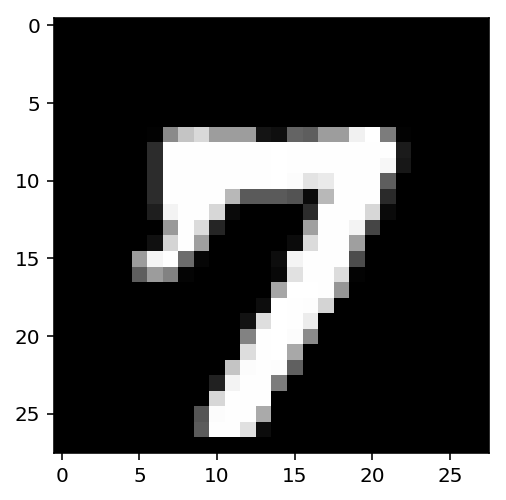

In [86]:
plt.imshow(images[4].numpy().squeeze(), cmap = 'Greys_r')

## Simple network using matrix multiplication

First we will build a simple network using matrix multiplication.
The networks we have seen so far are fully connected networks where each unit of one layer is connected to all the units of the next layer. In fully-connected networks, the input to each layer must be a one-dimensional vector (which can be stacked into a 2D tensor as a batch of multiple examples). however our images are 28x28 2d tensors, so we need to convert them into a 1D vector. We need to convert the batch of images with shape (64,1,28,28) to have a shape of (64, 784). 784 is 28 times 28. Typically this conversion is called flattening. We flattened 2D image into 1D vectors.

Following is a representation of how flattening of an image is done :

a 3 pixel x 3 pixel image is falttened as follows:

<img src="image_flatten.png"> 


In this network we need 10 output units as we are trying to predict 10 different digits. We want our network to predict the digit shown in an image, so what we'll do is calculate probabilities that the image is of any one digit or class. This ends up being a discrete probability distribution over the classes that tells us the most likely class for the image. Hence we need 10 output units for 10 classes(digits)

In [58]:
def activation(x):
    return 1/(1+torch.exp(-x))
# Flatten the input images
inputs = images.view(images.shape[0],-1)

# Create parameters
w1 = torch.randn((784,256))
b1 = torch.randn(256)

w2 = torch.randn(256,10)
b2 = torch.randn(10)

h = activation(torch.mm(inputs,w1)+b1) 

out = torch.mm(h,w2) +b2

Now we have 10 output of our network. We want to pass in an image to our network and get out a probability distribution over the classes that tells us the likely classes the image belongs to. 

Since right now the network is not trained, the probability for each class is roughly the same. 
To calculate the proability distibution, we will use softmax function.
The softmax funtion looks as follows:
<img src = 'softmax.svg'>
The softmax function will squish eah input Xi between 0 and 1 and normalize the values to give a propper distribution where the probabilities sum up to one.

In [59]:
# Solution
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim = 1).view(-1,1)

probabilities  = softmax(out)

#Does it have the right shape? Should be (64,10)
print(probabilities.shape)
# Does it sum to 1?
print(probabilities.sum(dim=1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## Building networks with pytorch

PyTorch provides a module nn that makes building networks much simpler. Here i'll show you how to build the same one as above with 784 inputs,256 hidden units, 10 output units and a softmax output. 

In [60]:
from torch import nn

In [61]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # inputs to the hidden layer
        self.hidden = nn.Linear(784,256)
        # output layer, 10 units - one for each digit
        self.output = nn.Linear(256,10)
        
        # Define sigmoid activation and softmax Output        
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(slef,x):
        # Pass input tensor through each of our operations
        x= self.hidden(x)
        x= self.sigmoid(x)
        x= self.softmax(x)
        x= self.output(x)
        x= self.softmax(x)
        
        return(x)

Lets go through the above code bit by bit.

 class Network(nn.module):
 
Here we are inheriting from nn.module. Combined with super().__init__() this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from nn.Module when you are creating a class for your network. The name of the class itself can be anything. 

    self.hidden = nn.Linear(784,256) 

This line creates a linear transformation, xW+b with 784 inputs and 256 outputs and assigns it to self.hidden. The module automatically creates weights and bias which are used in the forward method.The weight and bias tensors can be accessed once the network(net) is trained with net.hidden.weight. and net.hidden.bias

    self.output = nn.Linear(256,10)
    
Similarly creates another linear transformation with 256 inputs and 10 outputs


    self.sigmoid = nn.Sigmoid()
    self.softmax = nn.Softmax(dim=1)
    
Here the operations for sigmoid activation function and Softmax output have been defined.  Setting dim = 1 in nn.Softmax(dim=1) calculates softmax across columns. 

    def forward(self,x):
    
PyTorch networks  created with nn.Module must have a forward method defined. It takes tensor x and passes it through the operations defined in the __init__ method. 

       x = self.hidden(x)
       x = self.sigmoid(x)
       x = self.output(x)
       x = self.softmax(x) 

Here the input tensor x is passed through each operation and reassigned to x. We can see that the input tensor goes through the hidden layer followed by sigmoid,outpu and softmax. It doesnt matter what names you give here as long as the inputs and outputs of the operations match the network architecture  you want to build. The order in which you define things in the __init__ method doesn't matter, but you'll need  to sequence the operations correctly in the forward method. 

Now we create a network object. 
 

In [62]:
# create the network and look at its representation 
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

The above network representation can be better defined using torch.nn.functional module. This is the most common way you'll see networks defined as many operations are simple and element-wise functions. We normally import this module as F,import torch.nn.Functional as F.

In [63]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784,256)
        # Output layer, 10 units - one for each digit.
        self.output = nn.Linear(256,10)
        
    def forward(self,x):
        # Hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x))
        # Output layer with softmax activation 
        x = F.softmax(self.output(x), dim = 1)
        
        return(x)

## Activation functions 

So far we have been looking at the sigoid activation function, but in general any function can be used  as an activation function. The only requirement is that for a network to approximate a non linear function. A few widely used examples for activation functions are 1) tanH (hyperbolic tangent) and ReLU (rectified linear unit).

In practice the ReLU activation is used almost exclusively as the activation function for hidden layers. 

## Example of network with ReLU activation

In [80]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

In [65]:
model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

###  Initializing weights and biases

The weights and biases are initialized automatically. Buts its possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined and can be accessed with model.fc1.weight for instance. 

In [66]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[ 0.0085,  0.0077, -0.0279,  ...,  0.0245, -0.0024, -0.0220],
        [ 0.0344,  0.0160,  0.0032,  ..., -0.0017,  0.0092, -0.0131],
        [-0.0318, -0.0020, -0.0088,  ..., -0.0116,  0.0206, -0.0260],
        ...,
        [-0.0237,  0.0253, -0.0007,  ..., -0.0249,  0.0331,  0.0224],
        [-0.0134,  0.0315,  0.0036,  ..., -0.0086,  0.0251,  0.0155],
        [ 0.0208,  0.0111,  0.0091,  ...,  0.0109, -0.0019,  0.0072]],
       requires_grad=True)
Parameter containing:
tensor([ 4.1830e-03,  3.5203e-02,  3.2265e-02,  3.0018e-02,  3.1025e-02,
         2.9159e-02, -1.5200e-02, -2.1466e-02, -1.8370e-02, -7.4689e-03,
        -1.7414e-02, -1.0613e-02,  2.8992e-02,  2.9126e-02,  3.2692e-02,
        -3.5253e-02,  2.1608e-02,  2.9186e-02, -2.0895e-02,  2.3465e-02,
         2.9896e-02, -1.8389e-02,  1.5097e-02,  1.4773e-02,  2.2066e-02,
         3.2087e-02, -1.0866e-02, -3.0861e-02,  1.6471e-02,  9.5798e-03,
        -1.1943e-03,  1.0744e-02, -2.4249e-02,  1.6509e-0

For custom initialization, we want to modify these tensors in place. These are actually autograde variables, so we need to get back the actual tensors withe model.fc1.weight.data. Once we have the tensors, we can fill them up with zeros (for biases)  or random normal values. 

In [67]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [68]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[-0.0038,  0.0049,  0.0070,  ...,  0.0005, -0.0080,  0.0026],
        [-0.0084, -0.0145, -0.0138,  ..., -0.0030,  0.0021,  0.0148],
        [ 0.0043,  0.0130,  0.0062,  ...,  0.0070,  0.0188,  0.0063],
        ...,
        [ 0.0090, -0.0124,  0.0052,  ...,  0.0147,  0.0116, -0.0054],
        [ 0.0111, -0.0118,  0.0203,  ...,  0.0131,  0.0057,  0.0058],
        [-0.0016, -0.0057, -0.0060,  ..., -0.0008, -0.0079,  0.0162]])

### Forward Pass

Now that we have a network, let's see what happens when we pass an image.

In [69]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

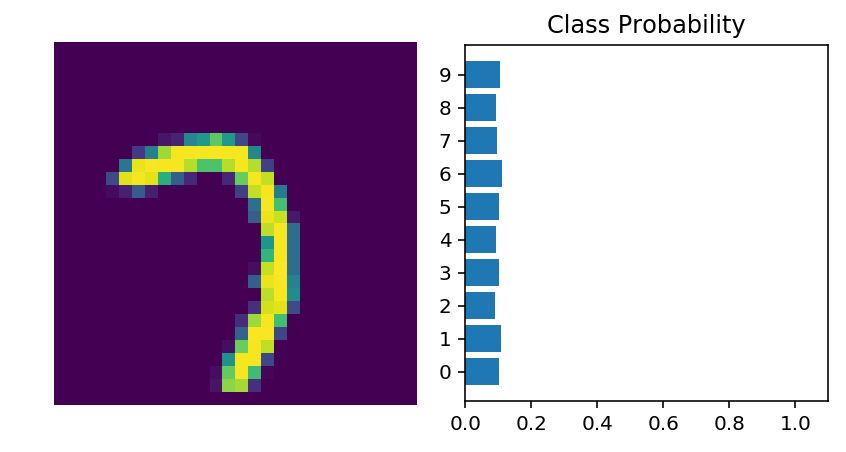

In [70]:
# Grab some data
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels)
images.resize_(64,1,784)

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:1])

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)




As you can see above, our network as no idea what the digit is. It's because we have not trained it yeat and all the weights are random

### Using nn.Sequential

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially  through operations, nn.Sequential. Using this to build a netwrok:

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


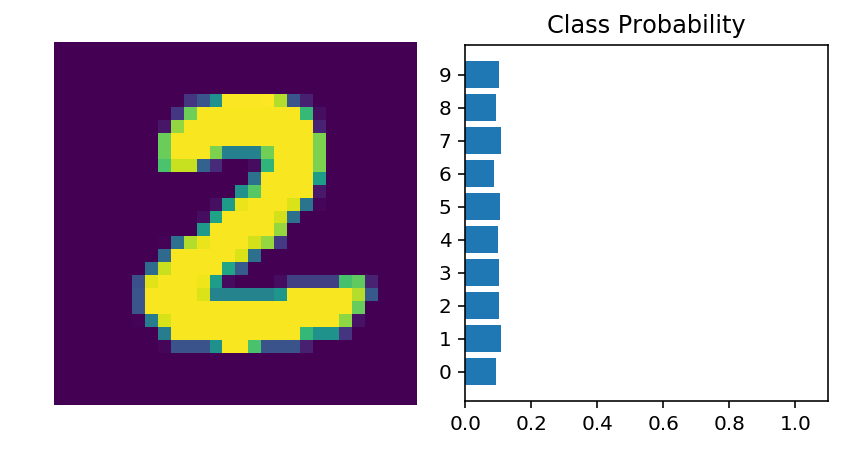

In [73]:
# HyperParameters for our netwrok:
input_size = 784
hidden_sizes = [128,64]
output_size = 10


# Build a feed forward netwrok
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output

images, labels = next(iter(trainloader))
images.resize_(images.shape[0],1,784) 
ps = model.forward(images[0,:])
view_classify(images[0].view(1,28,28),ps)


The operations are available by passing in the appropriate index. For example, if you want to get first Linear operation and look at the weights, you'd use model[0]

In [75]:
print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[-0.0229, -0.0127,  0.0111,  ...,  0.0122, -0.0159, -0.0011],
        [ 0.0234, -0.0121,  0.0108,  ...,  0.0159,  0.0269, -0.0149],
        [-0.0047,  0.0291, -0.0154,  ..., -0.0130, -0.0297,  0.0006],
        ...,
        [ 0.0290, -0.0140, -0.0253,  ...,  0.0277, -0.0144,  0.0114],
        [-0.0266,  0.0322, -0.0168,  ...,  0.0125,  0.0192, -0.0017],
        [-0.0119, -0.0015, -0.0240,  ..., -0.0142, -0.0180, -0.0047]],
       requires_grad=True)

An OrderedDict can also be created to name the individual layers and operations, instead of using inremental integers. Note that dictionary keys must be unique, so each operation must have a different name. 

In [76]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                        ('fc1',nn.Linear(input_size, hidden_sizes[0])),
                        ('fc2', nn.ReLU()),
                        ('fc3', nn.Linear(hidden_sizes[0],hidden_sizes[1])),
                        ('fc4', nn.ReLU()),
                        ('fc5', nn.Linear(hidden_sizes[1],output_size)),
                        ('fc6', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): ReLU()
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (fc6): Softmax(dim=1)
)

Now you can access layers by integers or names

In [77]:
print(model[0])

Linear(in_features=784, out_features=128, bias=True)


In [79]:
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
